# Clean up data set

## 1. Load what libraries you need.

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.style.use('ggplot')

## 2. Load the data from file. 
- index_col makes the date column an index. 
- header[1,2] defines the second and third row as multilevel columns (platform, the rest per platform).
https://stackoverflow.com/questions/22137723/convert-number-strings-with-commas-in-pandas-dataframe-to-float

In [14]:
fn='mock_data.csv'
df = pd.read_csv(fn,header=[1,2],index_col=0,parse_dates=True,thousands=',')
print(df.head() )#show top of table



            Google Play Unnamed: 2_level_0 Unnamed: 3_level_0  \
Day of Date ActiveUsers            Revenue              Day 1   
2019-04-01         3312                233             48.44%   
2019-04-02         3416                318             52.44%   
2019-04-03         3483                279             49.72%   
2019-04-04         3429                226             45.58%   
2019-04-05         3314                303             46.84%   

            Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
Day of Date             Day 10             Day 11             Day 12   
2019-04-01              11.33%              9.56%              7.78%   
2019-04-02              13.56%             11.57%             10.67%   
2019-04-03              12.29%             11.92%             11.36%   
2019-04-04              14.62%             12.69%             11.54%   
2019-04-05              15.25%             12.42%             10.89%   

            Unnamed: 7_level_0 Unnamed:

## 3. Deal with ugly confusing headers.
Thank you, 
https://stackoverflow.com/questions/30322581/pandas-read-multiindexed-csv-with-blanks

In [15]:
#pull the column level values into a DataFrame:
columns = pd.DataFrame(df.columns.tolist())

#then rename the Unnamed: columns to NaN:
columns.loc[columns[0].str.startswith('Unnamed:'), 0] = np.nan

#and then forward-fill the NaNs:
columns[0] = columns[0].fillna(method='ffill')

#Now we can find the remaining NaNs and fill them with empty strings:
mask = pd.isnull(columns[0])
columns[0] = columns[0].fillna('')

#To make the first two columns, A and B, indexable as df['A'] and df['B'] -- 
#as though they were single-leveled -- you could swap the values in the first and second columns:
columns.loc[mask, [0,1]] = columns.loc[mask, [1,0]].values

#Now you can build a new MultiIndex and assign it to df.columns:
df.columns = pd.MultiIndex.from_tuples(columns.to_records(index=False).tolist())
#df.columns.get_level_values(1)

print(df.dtypes)

Google Play  ActiveUsers     int64
             Revenue         int64
             Day 1          object
             Day 10         object
             Day 11         object
                             ...  
iOS          Day 5          object
             Day 6          object
             Day 7          object
             Day 8          object
             Day 9          object
Length: 62, dtype: object


## 4. It seems easier to deal with when stacking platforms on top of one another.
Some columns aren't numerical. Convert.

In [16]:
# stack the platform tables
stacked = df.stack(level=0)

# We now have 2 row indices, give them a name
stacked.index.names = ['Date','Platform']

#stacked.reset_index(1,inplace=True) # this makes index a normal column
#print(stacked.index)
#dates=list(stacked.index.get_level_values(0))

In [17]:
# https://stackoverflow.com/questions/25669588/convert-percent-string-to-float-in-pandas-read-csv

day_col=[col for col in stacked.columns if col.startswith('Day')]

for col in day_col:
    if col.startswith('Day'):
        stacked[col]=stacked[col].str.rstrip('%').astype('float') / 100.0  
        
#                     ^ use str funcs to elim '%'     ^ divide by 100
# could also be:     .str[:-1].astype(...#                     

## 5. We also want a month/year column

In [18]:
stacked['month_year'] = pd.DatetimeIndex(stacked.index.get_level_values(0)).to_period('M').strftime('%b %y')
#print(stacked.dtypes)

stacked
#print(stacked.index)

#print(dir(stacked['month_year']))
type(stacked['month_year'][0])

str

I'd really like to sort the columns by name.
- find Day columns: 
https://stackoverflow.com/questions/21285380/find-column-whose-name-contains-a-specific-string
https://stackoverflow.com/questions/27275236/pandas-best-way-to-select-all-columns-whose-names-start-with-x
https://stackoverflow.com/questions/11067027/re-ordering-columns-in-pandas-dataframe-based-on-column-name
- parse each string 
- extract day
- get a sort index
- then somehow apply this to a subset of cols.

# Calculations

## Ex. 1: Calculate the monthly averages of the daily active users (DAU) for all the months included in the dataset, for each platform and visualize it in a chart.

In [ ]:
https://www.earthdatascience.org/courses/intro-to-earth-data-science/scientific-data-structures-python/pandas-dataframes/run-calculations-summary-statistics-pandas-dataframes/

In [19]:
table = stacked.pivot_table(index=pd.to_datetime(stacked['month_year'], format='%b %y'),
                            columns='Platform',values='ActiveUsers')
table


Platform    Google Play         iOS
month_year                         
2019-04-01  3323.266667  154.400000
2019-05-01  2867.387097  119.645161
2019-06-01  2264.200000  117.433333
2019-07-01  1860.290323  117.419355
2019-08-01  1863.806452  143.064516
2019-09-01  2353.933333  314.633333
2019-10-01  1762.516129  338.580645
2019-11-01  1694.966667  239.400000

In [ ]:
list(stacked['month_year'].unique())

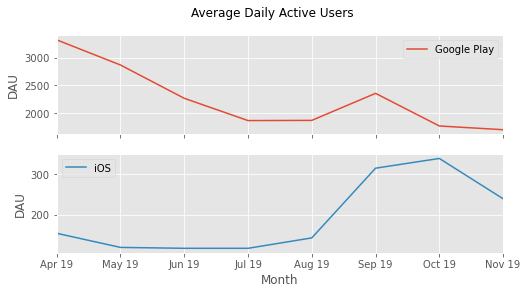

In [20]:
fig,ax=table.plot(figsize=(8,4), subplots=True, layout=(2, 1),title='Average Daily Active Users',
xlabel='Month',ylabel='DAU',xticks=table.index)

# must define both xtick and ticklabel!
# use axis object to change just one plot...
ax[-1].set_xticklabels(stacked['month_year'].unique());

# plt.sca(ax[0]) # set current axis



Overall, many more Google Play users than iOS. Makes sense as many more would have android phone, so much cheaper. Decreasing trend, then something exciting seems to happen in August. Excitement is relatively greater and lasts longer in iOS world.

## Ex. 2. Calculate the ARPDAU (Average Revenue per Daily Active User) 
per each day, separately for each platform. Visualize it in timeline in a chart.

In [21]:
#print(stacked.groupby(['month_year','Platform'],sort=False).groups.keys())
stacked['ActiveUsers'].describe()
stacked.head()


ActiveUsers   Day 1  Day 10  Day 11  Day 12  Day 13  \
Date       Platform                                                           
2019-04-01 Google Play         3312  0.4844  0.1133  0.0956  0.0778  0.0889   
           iOS                  179  0.3913  0.0435  0.0435  0.0000  0.0000   
2019-04-02 Google Play         3416  0.5244  0.1356  0.1157  0.1067  0.1049   
           iOS                  176  0.2917  0.0833  0.0833  0.0833  0.0833   
2019-04-03 Google Play         3483  0.4972  0.1229  0.1192  0.1136  0.1080   

                        Day 14  Day 15  Day 16  Day 17  ...  Day 29   Day 3  \
Date       Platform                                     ...                   
2019-04-01 Google Play  0.0778  0.0800  0.0711  0.0600  ...  0.0400  0.2867   
           iOS          0.0870  0.0870  0.0870  0.0435  ...  0.0000  0.1304   
2019-04-02 Google Play  0.1085  0.0850  0.0958  0.0778  ...  0.0470  0.2929   
           iOS          0.0833  0.0833  0.0833  0.0833  ...  0.0833  0.2917   
2019-04-03 Google Play  0.0987  0.0801  0.0857  0.0782  ...  0.0484  0.2756   

                         Day 4   Day 5   Day 6   Day 7   Day 8   Day 9  \
Date       Platform                                                      
2019-04-01 Google Play  0.2311  0.1889  0.1889  0.1600  0.1444  0.1244   
           iOS          0.1304  0.0870  0.1304  0.1739  0.1304  0.0870   
2019-04-02 Google Play  0.2622  0.2441  0.2043  0.1808  0.1700  0.1465   
           iOS          0.3750  0.2917  0.1667  0.2083  0.1250  0.1250   
2019-04-03 Google Play  0.2551  0.2160  0.2067  0.1769  0.1415  0.1304   

                        Revenue  month_year  
Date       Platform                          
2019-04-01 Google Play      233      Apr 19  
           iOS               26      Apr 19  
2019-04-02 Google Play      318      Apr 19  
           iOS               15      Apr 19  
2019-04-03 Google Play      279      Apr 19  

[5 rows x 32 columns]

In [22]:
stacked['AvgRevPerUser']=stacked['Revenue']/stacked['ActiveUsers']
table2 = stacked.pivot_table(index='Date',columns='Platform',values='AvgRevPerUser')
print(table2)

Platform    Google Play       iOS
Date                             
2019-04-01     0.070350  0.145251
2019-04-02     0.093091  0.085227
2019-04-03     0.080103  0.177215
2019-04-04     0.065908  0.000000
2019-04-05     0.091430  0.024540
...                 ...       ...
2019-11-26     0.019973  0.296992
2019-11-27     0.031919  0.101887
2019-11-28     0.025033  0.050584
2019-11-29     0.025426  0.115894
2019-11-30     0.021538  0.110032

[244 rows x 2 columns]


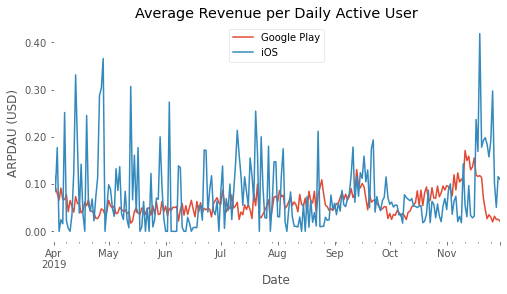

In [25]:
table2.plot(figsize=(8,4), subplots=False,title='Average Revenue per Daily Active User',
xlabel='Date',ylabel='ARPDAU (USD)')
ax=plt.gca()
ax.set_facecolor('white')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.legend(facecolor='white')
# must define both xtick and ticklabel!
# use axis object to change just one plot...
#ax[-1].set_xticklabels(stacked['month_year'].unique());

## Ex.3: Assuming the 1st of April 2019 is the Launch Date for the game, 
calculate the cumulative revenue of the “average” user that installed the game on the 1st of April for the first week after launch. To do so, use Return Rate and ARPDAU. Split the analysis by platform. 

https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/


In [26]:
# just extract the columns that contain day 1-7. What next? 
howmanydays = 7
day_cols=[col for col in stacked.columns if col.startswith('Day') and int(col[4:]) <= howmanydays]
# print(day_cols)
# for i in day_cols:
#     print(i[4:])
#     print(int(i[4:])<=7)
    
cumRev = stacked.reindex(sorted(day_cols,key=lambda x: int(x[4:])), axis=1)

In [27]:
cumRev['sumcumR']=0
for col in day_cols:
    print(col)
    cumRev[col+'_cumR']=cumRev[col]*stacked['AvgRevPerUser']
    cumRev['sumcumR']=cumRev['sumcumR']+(cumRev[col]*stacked['AvgRevPerUser'])

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7


In [28]:
whichDate='2019-04-01'
day_str=datetime.strptime(whichDate, '%Y-%m-%d').strftime('%d %B %Y')
#cumRev['sumcumR'] = cumRev['sumcumR'].map('${:,.2f}'.format) # bad idea, returns strings
cumRev_on_day = cumRev.loc[whichDate].groupby('Platform')['sumcumR'].sum()

print(cumRev_on_day)

Platform
Google Play    0.133820
iOS            0.195755
Name: sumcumR, dtype: float64


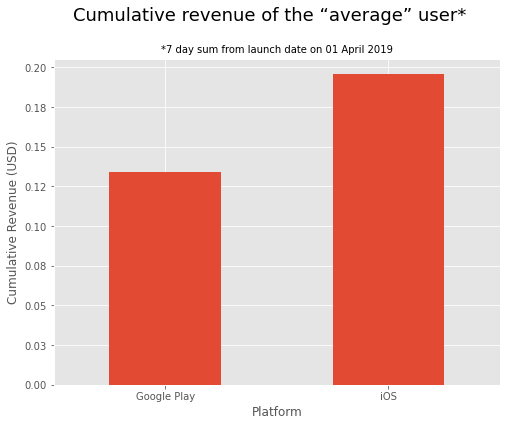

In [33]:
fig,ax=plt.subplots(1,1)
cumRev_on_day.plot.bar(figsize=(8,6), subplots=False,
     xlabel='Platform',ylabel='Cumulative Revenue (USD)',rot=0)

ax=plt.gca()

plt.suptitle('Cumulative revenue of the “average” user*', y=1, fontsize=18)
plt.title('*7 day sum from launch date on ' + day_str, fontsize=10)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
